### *__[Source](https://grouplens.org/datasets/movielens/)__: This dataset describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 20,000,263 ratings and 465,564 tag applications across 27,278 movies. Users were selected at random for inclusion. All selected users had rated at least 20 movies, and each user is represented by an id.*

### *We will parse, transform, and cluster this dataset. We will also evaluate and visualize the results.*

In [132]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

In [79]:
ratings_data = pd.read_csv('ratings.csv')
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## 1) Transforming Data

### *Transform the data into a user-movie ratings matrix. There should be 610 rows (one for each user) and 9724 columns (one for each movie). Each cell should contain the users rating for that movie. Assign a value of 0 for any missing values.*

In [112]:
ratings_data_pivoted = ratings_data.pivot_table(values='rating', index='userId', columns='movieId', fill_value=0) # construct pivot table w/ columns as movieId
del ratings_data_pivoted.columns.name # clean df
ratings_data_pivoted.columns = ratings_data_pivoted.columns.astype(str)
ratings_mat = ratings_data_pivoted.to_numpy() # convert to 2D np array
ratings_mat

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [6]:
ratings, counts = np.unique(ratings_mat, return_counts=True) # value counts of ratings
sorted(zip(counts, ratings)) # sort ratings by value counts

[(1370, 0.5),
 (1791, 1.5),
 (2811, 1.0),
 (5550, 2.5),
 (7551, 2.0),
 (8551, 4.5),
 (13136, 3.5),
 (13211, 5.0),
 (20047, 3.0),
 (26818, 4.0),
 (5830804, 0.0)]

The most common entry (rating) in the matrix is 0.0, as verified above. Matricies with such a property are called sparse matricies.

## 2) Principle Component Analysis

### *a) Transpose the matrix from Q1 so that rows refer to movies and columns refer to users. Mean center the data.*

In [201]:
trans_rat_mat = ratings_mat.T # transpose original ratings matrix
trans_rat_mat = StandardScaler(with_std=False).fit_transform(trans_rat_mat) # standardize data

### *b) Apply PCA with number of components k = 2 to reduce the dimensionality of the movies. Plot the new representations of the movies with a scatter plot.*

In [202]:
pca = PCA(n_components=2) # apply PCA w/ 2 principal components
red_rat_mat = pca.fit_transform(trans_rat_mat)

Text(0.5, 1.0, '2 Component PCA')

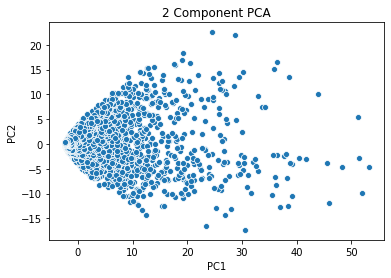

In [203]:
sns.scatterplot(red_rat_mat[:,0], red_rat_mat[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2 Component PCA')

### *c) Determine how much of the variance is explained by each of these first two components. Can you observe the difference in variance between them in the plot?*

In [242]:
pca.explained_variance_ratio_

array([0.17620942, 0.04189505])

The first principal component (PC1) explains ~17.62% of the variance of the data, and the second principal component (PC2) explains ~4.19%. In total, the first two components explain ~2.18% of the variance of the data. The scatterplot above clearly depicts the difference in variance between the two principal compenents; the range and spread of PC1 is much greater than that of PC2's.

### *d) Determine the “intrinsic” dimensionality of the movies, by finding the number of principal components that are needed to explain 80% of the variance of the data. Discuss how this compares to k = 2 and how this may impact the quality of the visualization above.*

In [143]:
pca = PCA() # apply PCA w/ all features
pca.fit(trans_rat_mat)
pca_var_cumsum = pca.explained_variance_ratio_.cumsum() # find cumsum of explained variance ratios of each principal component
[elem[0] for elem in enumerate(pca_var_cumsum) if elem[1] >= 0.8][0] # find index of cumsum variance list (above) such that cumsum is >= 0.8

152

152 principal components are needed to explain 80% of the variance of the data. 2 principal components explain approximately 22% of the variance, while adding 150 more components will raise that percentage to 80%. Including these additional components will make it significantly harder to visualize the data and examine the variability, compared to a graph with 2 components. 

## 3) Clustering

In [228]:
trans_rat_mat = ratings_mat.T # transpose original ratings matrix
trans_rat_dat = ratings_data_pivoted.transpose() # tranpose original ratings dataframe

### *a) For values of k = [2, 4, 8, 16, 32], apply k-means and measure the inertia for each value of k. Plot the resulting inertia scores for each choice of k.*

In [105]:
def construct_elbow_curve(ks): # func to construct elbow curve
    inertia_scores = [] # list to store inertia for each k
    for k in ks:
        km = KMeans(n_clusters=k)
        km.fit(ratings_mat)
        inertia_scores.append(km.inertia_)
    sns.lineplot(ks, inertia_scores, marker='o')
    plt.title('Elbow Curve')
    plt.xlabel('K')
    plt.ylabel('Inertia')

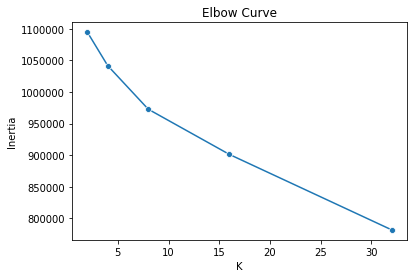

In [106]:
construct_elbow_curve(ks = [2, 4, 8, 16, 32])

The elbow curve below is more comprehensive, showing inertia scores for each k between 1 and 14.

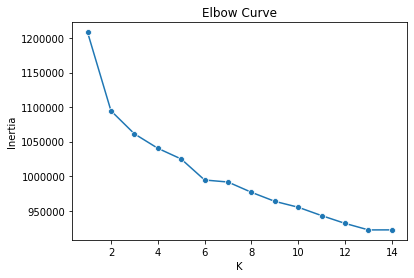

In [108]:
construct_elbow_curve(ks = [k for k in range(1, 15)])

### *b) From the above results, choose an appropriate value of k from the plot and support your choice.*

A large drop in the elbow curve suggests that increasing k will optimize the model. However, the optimal number of clusters is where the decline begins to settle (at the elbow), which is at k = 2. 

### *c) What kind of common characteristic would you expect the movies clustered together to have? Is this type of interpretation always possible?*

Generally, I would expect movies clustered together to have similar average ratings across all users. We will proceed to check if this is true.

In [229]:
km = KMeans(n_clusters=2, random_state=2)
km.fit(trans_rat_mat)
cluster_labels = km.predict(trans_rat_mat)
trans_rat_dat['cluster labels'] = cluster_labels # add cluster labels to dataframe

**Cluster 0:**

In [208]:
trans_rat_dat[trans_rat_dat['cluster labels'] == 0].describe()

userId,1,2,3,4,5,6,7,8,9,10,...,602,603,604,605,606,607,608,609,610,cluster labels
count,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,...,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.000000,9056.0
mean,0.041961,0.005245,0.008447,0.047151,0.004638,0.086131,0.010490,0.001546,0.009055,0.030422,...,0.021312,0.267999,0.021312,0.044004,0.322880,0.030146,0.132951,0.004638,0.365559,0.0
std,0.430999,0.148432,0.193090,0.436196,0.139339,0.548158,0.180037,0.069691,0.170509,0.332048,...,0.266040,0.982259,0.275422,0.373799,1.056149,0.346437,0.645840,0.123364,1.108950,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,4.500000,5.000000,5.000000,5.000000,4.000000,5.000000,0.0


**Cluster 1:**

In [209]:
trans_rat_dat[trans_rat_dat['cluster labels'] == 1].describe()

userId,1,2,3,4,5,6,7,8,9,10,...,602,603,604,605,606,607,608,609,610,cluster labels
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,...,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.0
mean,0.947605,0.100299,0.027695,0.510479,0.176647,0.474551,0.592814,0.230539,0.101796,0.274701,...,0.396707,1.318862,0.232036,0.465569,1.727545,0.651198,2.096557,0.118263,2.233533,1.0
std,1.846089,0.628866,0.296753,1.332855,0.800258,1.296152,1.408768,0.919958,0.660605,0.979430,...,1.181994,1.860616,0.898970,1.223035,1.920814,1.487443,1.839318,0.619108,2.118162,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,3.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,0.000000,0.000000,4.000000,0.000000,4.000000,0.000000,4.000000,1.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,1.0


From the above statistics, it seems that the clusters are primarily assigned based on the average ratings of movies. In cluster 0, users seem to have given all movies lower ratings, while in cluster 1, the average ratings are higher. This is further verified below.

In [210]:
trans_rat_dat.groupby('cluster labels').mean().mean(axis=1)

cluster labels
0    0.030306
1    0.455646
dtype: float64

We can also see that, overall, cluster 1 has more movies with higher ratings compared to cluster 0.

This type of interpretation is not always possible, nor useful. In this example, we have many missing values and are assigning those to 0. This could heavily skew the data, since there is such a large number of missing values. In addition, clustering of data is always possible, but there can be multiple interpretations or no conclusive interpretations.

## 4) Singular Value Decomposition

In [211]:
trans_rat_mat = ratings_mat.T # transpose original ratings matrix
trans_rat_dat = ratings_data_pivoted.transpose() # transpose original ratings dataframe

### *a) Apply SVD with number of components k = 32. Plot the resulting singular values.*

Text(0, 0.5, 'Singular Value')

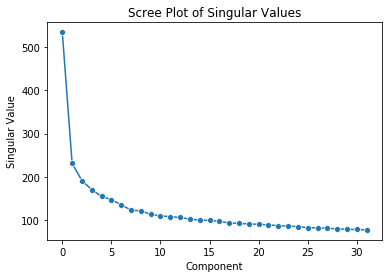

In [145]:
svd = TruncatedSVD(n_components=32)
svd.fit(trans_rat_mat)
sns.lineplot([i for i in range(32)], svd.singular_values_, marker='o')
plt.title('Scree Plot of Singular Values')
plt.xlabel('Component')
plt.ylabel('Singular Value')

### *b) For each of the values of k = [2,4,8,16,32] considered above, report the sum of the explained variance ratio. Plot these values against the corresponding values of k. Discuss how the results compare to the inertia values above and whether it supports your choice of k.*

In [197]:
svd = TruncatedSVD(n_components=32)
svd.fit(trans_rat_mat)

TruncatedSVD(algorithm='randomized', n_components=32, n_iter=5,
             random_state=None, tol=0.0)

In [212]:
def construct_sum_explained_ratio(ks):
    sns.lineplot(ks, [np.cumsum(svd.explained_variance_ratio_)[k - 1] for k in ks], marker='o')
    plt.title('Sum of Explained Variance Ratios vs. Dimensions')
    plt.xlabel('Dimensions')
    plt.ylabel('Sum of Explained Variance Ratios')
    return [np.cumsum(svd.explained_variance_ratio_)[k - 1] for k in ks]

**Sum of Explained Variance Ratio (k = [2, 4, 8, 16, 32])**

[0.21642917579331902,
 0.2641414749088338,
 0.325013148492343,
 0.39739500311674575,
 0.48967449226926635]

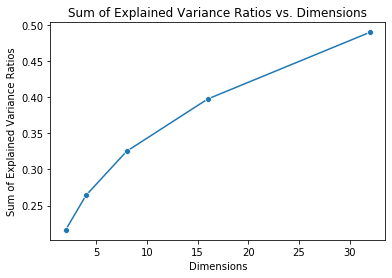

In [215]:
construct_sum_explained_ratio(ks = [2, 4, 8, 16, 32])

**Sum of Explained Variance Ratio (k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])**

[0.17453428142994507,
 0.21642917579331902,
 0.2427663742500606,
 0.2641414749088338,
 0.2827320780776138,
 0.2988524335729331,
 0.3132252539857975,
 0.325013148492343,
 0.33649702957674676,
 0.3464902914937754,
 0.35585414275464067,
 0.36492252909352413,
 0.37372144647029826,
 0.38186464679232446]

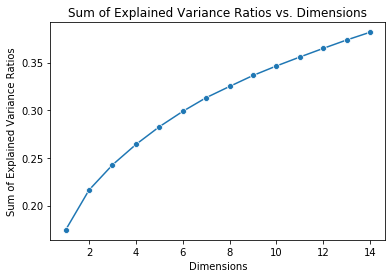

In [214]:
construct_sum_explained_ratio(ks = [k for k in range(1, 15)])

The results are consistent with the intertia values computed above. In the graphs above, as the number of components increase, the sum of the explained variance ratios also increase, but at a lower rate for each added component. In the elbow curves, as the number of components increase, the inertia scores decrease, but at a lower rate for each added component. This shows how adding many components can overfit the model, while not significantly adding to the cumulative sum of the explained variance ratios. The graphs above also show that k = 2 was a good selection, as increasing k will not significantly increase the total explained variance. 

### *c) Apply SVD with k = 2 and transform the data.*

In [243]:
svd = TruncatedSVD()
red_rat_mat = svd.fit_transform(trans_rat_mat)
red_rat_mat

array([[ 3.76498279e+01, -6.37760571e+00],
       [ 2.05961932e+01, -4.77930637e-01],
       [ 8.50418185e+00, -5.71568213e+00],
       ...,
       [ 3.45682002e-02,  1.38187006e-01],
       [ 3.45682002e-02,  1.38187006e-01],
       [ 1.45217552e-01,  2.94177789e-01]])

### *d) Plot the results (for k = 2) and color the movies by the cluster memberships you found above. Discuss any patterns you can see and compare them to the previous analysis (either from clustering or PCA).*

**8 Clusters:**

Text(0, 0.5, 'Component 2')

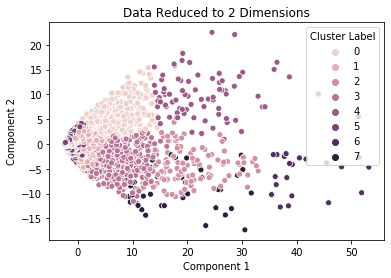

In [240]:
km = KMeans(n_clusters=8, random_state=2).fit(trans_rat_mat)
sns.scatterplot(red_rat_mat[:,0], red_rat_mat[:,1], hue=km.labels_, legend='full')
plt.legend(title='Cluster Label')
plt.title('Data Reduced to 2 Dimensions')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

**2 Clusters:** 
<br/>
*Using elbow curve with k $\in$ [1, 14] shows using 2 clusters is most optimal.*

Text(0, 0.5, 'Component 2')

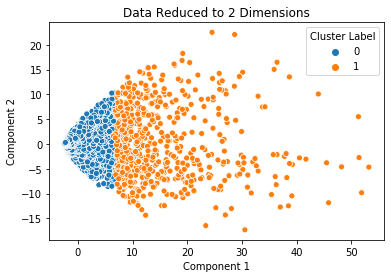

In [231]:
sns.scatterplot(red_rat_mat[:,0], red_rat_mat[:,1], hue=km.labels_)
plt.legend(title='Cluster Label')
plt.title('Data Reduced to 2 Dimensions')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

The graph above (produced by applying SVD) seems identical to the one produced by applying PCA with 2 principal components. The graph shows how movies are clustered based on their proximities to one another. There seems to be a high density of points in cluster 0, while cluster 1 has a larger spread within the cluster. This also makes sense as the x axis should have larger variability compared to the y axis.